#### Lab 3 Decision Trees ####

#### Decision Tree Classification ####

Importing packages


In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier as SklearnDT
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from classifier_new import build_classification_tree, prune_classification_tree
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt

Loading data    

In [65]:
data = pd.read_csv('data/stars.csv')
data.head()


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [66]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [67]:
def load_and_preprocess_data(add_missing_values=False, missing_rate=0.1):
    """Helper function to load and preprocess the stars dataset"""
    data = pd.read_csv('data/stars.csv')
    
    # Convert categorical columns to numeric
    le_color = LabelEncoder()
    le_spectral = LabelEncoder()
    X = data.copy()
    X['Star color'] = le_color.fit_transform(X['Star color'])
    X['Spectral Class'] = le_spectral.fit_transform(X['Spectral Class'])
    
    # Get target and features
    y = X['Star type'].values
    X = X.drop('Star type', axis=1).astype(float)
    
    if add_missing_values:
        np.random.seed(42)
        ix = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
        for row, col in random.sample(ix, int(round(missing_rate * len(ix)))):
            X.iloc[row, col] = np.nan
    
    return X.values, y

In [68]:
class_data = load_and_preprocess_data


In [69]:
# Set random seeds
np.random.seed(42)
random.seed(42)

# Test with complete data
X, y = load_and_preprocess_data(add_missing_values=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Test with missing data
X_missing, y_missing = load_and_preprocess_data(add_missing_values=True, missing_rate=0.1)
X_train_missing, X_test_missing, y_train_missing, y_test_missing = train_test_split(
X_missing, y_missing, test_size=0.2, random_state=42, stratify=y_missing)

results = []

# Test all methods
methods = [
    ('Custom Entropy', 'entropy', False),
    ('Custom Donskoy', 'donskoy', False),
    ('Sklearn', None, True)
]

for name, criterion, is_sklearn in methods:
    # Complete data
    start_time = time.time()
    if is_sklearn:
        model = SklearnDT(criterion='entropy', max_depth=4, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model = build_classification_tree(X_train, y_train, criterion=criterion, max_depth=4)
        y_pred = np.array([np.argmax(model.predict(x)) for x in X_test])
    train_time = time.time() - start_time
    acc_complete = accuracy_score(y_test, y_pred)
    
    # Missing data
    start_time = time.time()
    if is_sklearn:
        X_train_imputed = np.nan_to_num(X_train_missing, nan=0)
        X_test_imputed = np.nan_to_num(X_test_missing, nan=0)
        model = SklearnDT(criterion='entropy', max_depth=7, random_state=42)
        model.fit(X_train_imputed, y_train_missing)
        y_pred = model.predict(X_test_imputed)
    else:
        model = build_classification_tree(X_train_missing, y_train_missing, criterion=criterion, max_depth=7)
        y_pred = np.array([np.argmax(model.predict(x)) for x in X_test_missing])
    train_time_missing = time.time() - start_time
    acc_missing = accuracy_score(y_test_missing, y_pred)
    
    results.append({
        'Method': name,
        'Complete Data Accuracy': f"{acc_complete:.4f}",
        'Missing Data Accuracy': f"{acc_missing:.4f}",
        'Complete Data Time (ms)': f"{train_time*1000:.2f}",
        'Missing Data Time (ms)': f"{train_time_missing*1000:.2f}"
    })

# Create and display comparison table
df = pd.DataFrame(results)
df = df.set_index('Method')
print("\nComparison Table:")
df


Comparison Table:


,Complete Data Accuracy,Missing Data Accuracy,Complete Data Time (ms),Missing Data Time (ms)
Method,,,,
Custom Entropy,0.9792,0.8750,156.68,109.39
Custom Donskoy,0.9792,0.8333,100.24,70.35
Sklearn,1.0000,0.9167,0.00,0.00



=== Time Complexity Analysis ===


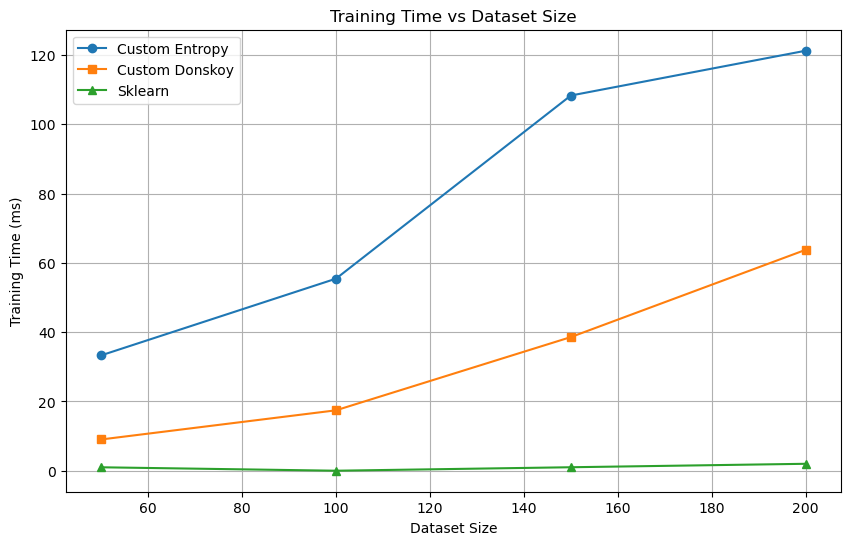


Training times (milliseconds):


,entropy_train,donskoy_train,sklearn_train,donskoy_entropy_ratio
size,,,,
50,33.30,9.02,0.99,0.27
100,55.44,17.44,0.00,0.31
150,108.32,38.58,1.00,0.36
200,121.25,63.78,2.00,0.53


In [70]:
print("\n=== Time Complexity Analysis ===")

# Load full dataset
X_full, y_full = load_and_preprocess_data(add_missing_values=False)

# Test different dataset sizes
sizes = [50, 100, 150, 200]
results = {
    'size': sizes,
    'entropy_train': [],
    'donskoy_train': [],
    'sklearn_train': []
}

for size in sizes:
    # Sample dataset
    indices = np.random.choice(len(X_full), size=size, replace=False)
    X = X_full[indices]
    y = y_full[indices]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Test all implementations
    for criterion, impl in [('entropy', 'Custom Entropy'), ('donskoy', 'Custom Donskoy'), 
                            (None, 'Sklearn')]:
        start_time = time.time()
        if impl == 'Sklearn':
            tree = SklearnDT(criterion='entropy', max_depth=4, random_state=42)
            tree.fit(X_train, y_train)
        else:
            tree = build_classification_tree(X_train, y_train, criterion=criterion, max_depth=4)
        train_time = time.time() - start_time
        
        key = 'sklearn_train' if impl == 'Sklearn' else f'{criterion}_train'
        results[key].append(train_time * 1000)  # Convert to ms

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(sizes, results['entropy_train'], 'o-', label='Custom Entropy')
plt.plot(sizes, results['donskoy_train'], 's-', label='Custom Donskoy')
plt.plot(sizes, results['sklearn_train'], '^-', label='Sklearn')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (ms)')
plt.title('Training Time vs Dataset Size')
plt.legend()
plt.grid(True)
plt.show()

# Print summary
df = pd.DataFrame(results).set_index('size')
df['donskoy_entropy_ratio'] = df['donskoy_train'] / df['entropy_train']
print("\nTraining times (milliseconds):")
df.round(2)

### Decision Tree Regression ###


Loading Data

In [71]:
def load_and_preprocess_data(add_missing_values=False, missing_rate=0.1, use_synthetic=False):
    # Load stars dataset
    data = pd.read_csv('data/stars.csv')
    
    # Use Luminosity as target and other numerical features as predictors
    y = data['Luminosity(L/Lo)'].values
    X = data[['Temperature (K)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']].copy()
    
    # Scale features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
    
    if add_missing_values:
        np.random.seed(42)
        ix = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
        mask = np.zeros_like(X, dtype=bool)
        for row, col in random.sample(ix, int(round(missing_rate * len(ix)))):
            mask[row, col] = True
        X = np.where(mask, np.nan, X)
    
    return X, y, scaler_y

In [72]:
from regressor import build_regression_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor as SklearnDT

print("\n=== Comparison of All Methods ===")

# Set random seeds
np.random.seed(42)
random.seed(42)

# Test with complete data
X, y, scaler = load_and_preprocess_data(add_missing_values=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Test with missing data
X_missing, y_missing, _ = load_and_preprocess_data(add_missing_values=True, missing_rate=0.1)
X_train_missing, X_test_missing, y_train_missing, y_test_missing = train_test_split(
    X_missing, y_missing, test_size=0.2, random_state=42)

results = []

# Test both methods
methods = [
    ('Custom Tree', False),
    ('Sklearn', True)
]

for name, is_sklearn in methods:
    # Complete data
    start_time = time.time()
    if is_sklearn:
        model = SklearnDT(criterion='squared_error', max_depth=4, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model = build_regression_tree(X_train, y_train, max_depth=4)
        y_pred = np.array([model.predict(x) for x in X_test])
    train_time = time.time() - start_time
    mse_complete = mean_squared_error(y_test, y_pred)
    r2_complete = r2_score(y_test, y_pred)
    
    # Missing data
    start_time = time.time()
    if is_sklearn:
        # Give sklearn the same dataset with missing values
        try:
            model = SklearnDT(criterion='squared_error', max_depth=4, random_state=42)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_train_missing, y_train_missing)
                y_pred = model.predict(X_test_missing)
            mse_missing = mean_squared_error(y_test_missing, y_pred)
            r2_missing = r2_score(y_test_missing, y_pred)
        except Exception as e:
            print(f"\nSklearn failed with missing values: {str(e)}")
            mse_missing = float('nan')
            r2_missing = float('nan')
    else:
        model = build_regression_tree(X_train_missing, y_train_missing, max_depth=4)
        y_pred = np.array([model.predict(x) for x in X_test_missing])
        mse_missing = mean_squared_error(y_test_missing, y_pred)
        r2_missing = r2_score(y_test_missing, y_pred)
    train_time_missing = time.time() - start_time
    
    results.append({
        'Method': name,
        'Complete MSE': f"{mse_complete:.4f}",
        'Complete R²': f"{r2_complete:.4f}",
        'Missing MSE': f"{mse_missing:.4f}",
        'Missing R²': f"{r2_missing:.4f}",
        'Complete Time (ms)': f"{train_time*1000:.2f}",
        'Missing Time (ms)': f"{train_time_missing*1000:.2f}"
    })

# Create comparison table
df = pd.DataFrame(results).set_index('Method')
print("\nComparison Table:")
df


=== Comparison of All Methods ===

Comparison Table:


,Complete MSE,Complete R²,Missing MSE,Missing R²,Complete Time (ms),Missing Time (ms)
Method,,,,,,
Custom Tree,0.5756,0.5942,0.6983,0.5076,77.78,69.82
Sklearn,0.5101,0.6403,0.6063,0.5725,0.00,0.00



=== Time Complexity Analysis ===


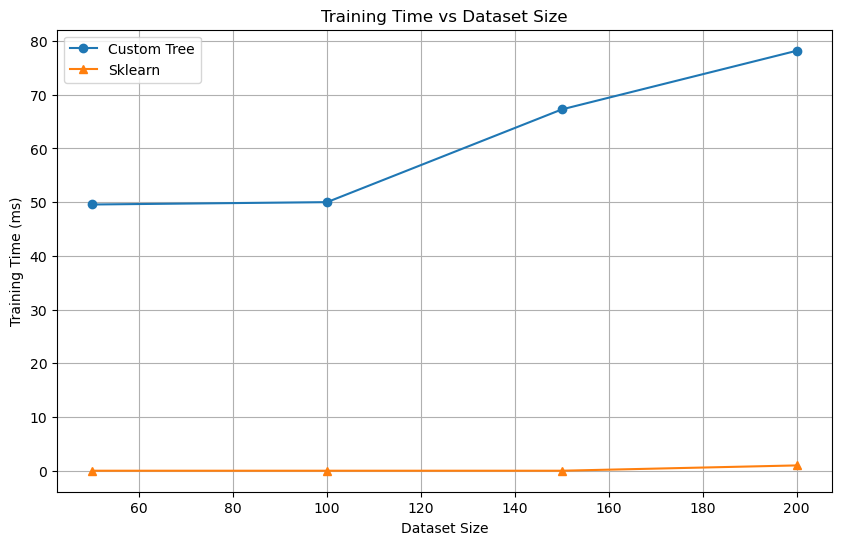


Training times (milliseconds):


,custom_train,sklearn_train
size,,
50,49.56,0.00
100,50.00,0.00
150,67.27,0.00
200,78.19,0.99


In [73]:
print("\n=== Time Complexity Analysis ===")

# Load full dataset
X_full, y_full, _ = load_and_preprocess_data(add_missing_values=False)

# Test different dataset sizes
sizes = [50, 100, 150, 200]
results = {
    'size': sizes,
    'custom_train': [],
    'sklearn_train': []
}

for size in sizes:
    # Sample dataset
    indices = np.random.choice(len(X_full), size=size, replace=False)
    X = X_full[indices]
    y = y_full[indices]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Test both implementations
    # Custom implementation
    start_time = time.time()
    tree = build_regression_tree(X_train, y_train, max_depth=4)
    train_time = time.time() - start_time
    results['custom_train'].append(train_time * 1000)
    
    # Sklearn implementation
    start_time = time.time()
    sklearn_tree = SklearnDT(criterion='squared_error', max_depth=4, random_state=42)
    sklearn_tree.fit(X_train, y_train)
    train_time = time.time() - start_time
    results['sklearn_train'].append(train_time * 1000)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(sizes, results['custom_train'], 'o-', label='Custom Tree')
plt.plot(sizes, results['sklearn_train'], '^-', label='Sklearn')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (ms)')
plt.title('Training Time vs Dataset Size')
plt.legend()
plt.grid(True)
plt.show()

# Print summary
df = pd.DataFrame(results).set_index('size')
print("\nTraining times (milliseconds):")
df.round(2)


### Pruning ###

##### Classification Tree Pruning

In [98]:
print("\n=== Testing Tree Pruning ===")

data = pd.read_csv('data/stars.csv')
    
    # Prepare features and target
X = data[['Temperature (K)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']].values
le = LabelEncoder()
y = le.fit_transform(data['Star type'].values)
n_classes = len(np.unique(y))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nDataset splits:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")
print(f"Number of classes: {n_classes}")

# Build a deep tree (potentially overfit)
tree = build_classification_tree(X_train, y_train, criterion="entropy", max_depth=15)

# Get pre-pruning performance
y_pred_before = []
for x in X_test:
    probs = tree.predict(x)
    pred = np.argmax(probs)
    y_pred_before.append(pred)
y_pred_before = np.array(y_pred_before)
accuracy_before = np.mean(y_pred_before == y_test)

# Count nodes before pruning
def count_nodes(node):
    if node is None or node.beta is None:
        return 1
    return 1 + count_nodes(node.left) + count_nodes(node.right)

nodes_before = count_nodes(tree)

print("\nBefore Pruning:")
print(f"Number of nodes: {nodes_before}")
print(f"Test accuracy: {accuracy_before:.4f}")

# Prune the tree
print("\nPruning tree...")
pruned_tree = prune_classification_tree(tree, X_val, y_val, n_classes)

# Get post-pruning performance
y_pred_after = []
for x in X_test:
    probs = pruned_tree.predict(x)
    pred = np.argmax(probs)
    y_pred_after.append(pred)
y_pred_after = np.array(y_pred_after)
accuracy_after = np.mean(y_pred_after == y_test)
nodes_after = count_nodes(pruned_tree)

print("\nAfter Pruning:")
print(f"Number of nodes: {nodes_after}")
print(f"Test accuracy: {accuracy_after:.4f}")

print(f"\nResults:")
print(f"Node reduction: {nodes_before - nodes_after} nodes ({(1 - nodes_after/nodes_before)*100:.1f}%)")
print(f"Accuracy change: {(accuracy_after - accuracy_before)*100:+.2f}%")



=== Testing Tree Pruning ===

Dataset splits:
Training: 144 samples
Test: 48 samples
Number of classes: 6

Before Pruning:
Number of nodes: 11
Test accuracy: 0.5625

Pruning tree...

After Pruning:
Number of nodes: 7
Test accuracy: 0.6875

Results:
Node reduction: 4 nodes (36.4%)
Accuracy change: +12.50%


#### Regression Tree Pruning

In [101]:
from regressor import prune_regression_tree
print("\n=== Testing Tree Pruning ===")

# Load stars dataset
data = pd.read_csv('data/stars.csv')

# Prepare features and target
X = data[['Temperature (K)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']].values
y = data['Luminosity(L/Lo)'].values

# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nDataset splits:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

# Build a deep tree (potentially overfit)
tree = build_regression_tree(X_train, y_train, max_depth=10)

# Get pre-pruning performance
y_pred_before = np.array([tree.predict(x) for x in X_test])
mse_before = mean_squared_error(y_test, y_pred_before)
r2_before = r2_score(y_test, y_pred_before)

# Count nodes before pruning
def count_nodes(node):
    if node is None or node.beta is None:
        return 1
    return 1 + count_nodes(node.left) + count_nodes(node.right)

nodes_before = count_nodes(tree)

print("\nBefore Pruning:")
print(f"Number of nodes: {nodes_before}")
print(f"Test MSE: {mse_before:.4f}")
print(f"Test R²: {r2_before:.4f}")

# Prune the tree
print("\nPruning tree...")
pruned_tree = prune_regression_tree(tree, X_val, y_val)

# Get post-pruning performance
y_pred_after = np.array([pruned_tree.predict(x) for x in X_test])
mse_after = mean_squared_error(y_test, y_pred_after)
r2_after = r2_score(y_test, y_pred_after)
nodes_after = count_nodes(pruned_tree)

print("\nAfter Pruning:")
print(f"Number of nodes: {nodes_after}")
print(f"Test MSE: {mse_after:.4f}")
print(f"Test R²: {r2_after:.4f}")


print(f"\nResults:")
print(f"Node reduction: {nodes_before - nodes_after} nodes ({(1 - nodes_after/nodes_before)*100:.1f}%)")
print(f"MSE change: {(mse_after - mse_before):.4f} ({(mse_after/mse_before - 1)*100:+.1f}%)")
print(f"R² change: {(r2_after - r2_before):.4f} ({(r2_after/r2_before - 1)*100:+.1f}%)")



=== Testing Tree Pruning ===

Dataset splits:
Training: 144 samples
Validation: 48 samples
Test: 48 samples

Before Pruning:
Number of nodes: 45
Test MSE: 0.6362
Test R²: 0.5431

Pruning tree...

After Pruning:
Number of nodes: 9
Test MSE: 0.6921
Test R²: 0.5030

Results:
Node reduction: 36 nodes (80.0%)
MSE change: 0.0560 (+8.8%)
R² change: -0.0402 (-7.4%)
